# LightGBM SHAP for predicting use of thrombolysis

This model use 10 features:

* stroke_team_id
* stroke_severity
* prior_disability
* age
* infarction
* onset_to_arrival_time
* precise_onset_known
* onset_during_sleep
* arrival_to_scan_time
* afib_anticoagulant

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from dataclasses import dataclass
from lightgbm import LGBMClassifier

## Set up paths and filenames

In [2]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = './data/'
    output_folder = './output/'
    model_folder = './models'
    model_text = 'lgbm_decision_'
    notebook: str = '02_'

paths = Paths()

## Load data

In [3]:
# Load data
train = pd.read_csv(paths.data_read_path + 'cohort_10000_train.csv')
train['stroke_team_id'] = train['stroke_team_id'].astype('category')
test = pd.read_csv(paths.data_read_path + 'cohort_10000_test.csv')
test['stroke_team_id'] = test['stroke_team_id'].astype('category')

# Split X and y
X_train = train.drop('thrombolysis', axis=1)
X_test = test.drop('thrombolysis', axis=1)
y_train = train['thrombolysis']
y_test = test['thrombolysis']

# Get features
features = list(X_train)

In [4]:
features

['stroke_team_id',
 'stroke_severity',
 'prior_disability',
 'age',
 'infarction',
 'onset_to_arrival_time',
 'precise_onset_known',
 'onset_during_sleep',
 'arrival_to_scan_time',
 'afib_anticoagulant']

## Fit model

In [5]:
# Define model
model = LGBMClassifier(random_state=42, num_leaves=300)

# Fit model
model.fit(X_train, y_train)

# Get predictions
predicted = model.predict(X_test)
predicted_proba = model.predict_proba(X_test)[:,1]

# Show overall accuracy
accuracy = np.mean(predicted == y_test)
print (f'Accuracy: {accuracy:.3f}')

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
categorical_feature in param dict is overridden.


Accuracy: 0.851


## Fit SHAP

In [6]:
explainer = shap.TreeExplainer(model)
shap_values_extended = explainer(X_test)
shap_values = explainer.shap_values(X_test)
shap_values_extended[0]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


.values =
array([[-0.09080716,  0.09080716],
       [-1.12481672,  1.12481672],
       [ 0.59306583, -0.59306583],
       [ 0.06418312, -0.06418312],
       [-1.34686689,  1.34686689],
       [-0.0242374 ,  0.0242374 ],
       [-0.42376993,  0.42376993],
       [-0.05820977,  0.05820977],
       [-0.71310809,  0.71310809],
       [-0.31008248,  0.31008248]])

.base_values =
array([ 2.8549286, -2.8549286])

.data =
array([90. ,  8. ,  3. , 82.5,  1. , 83. ,  1. ,  0. , 20. ,  0. ])

## Show example waterfall plot

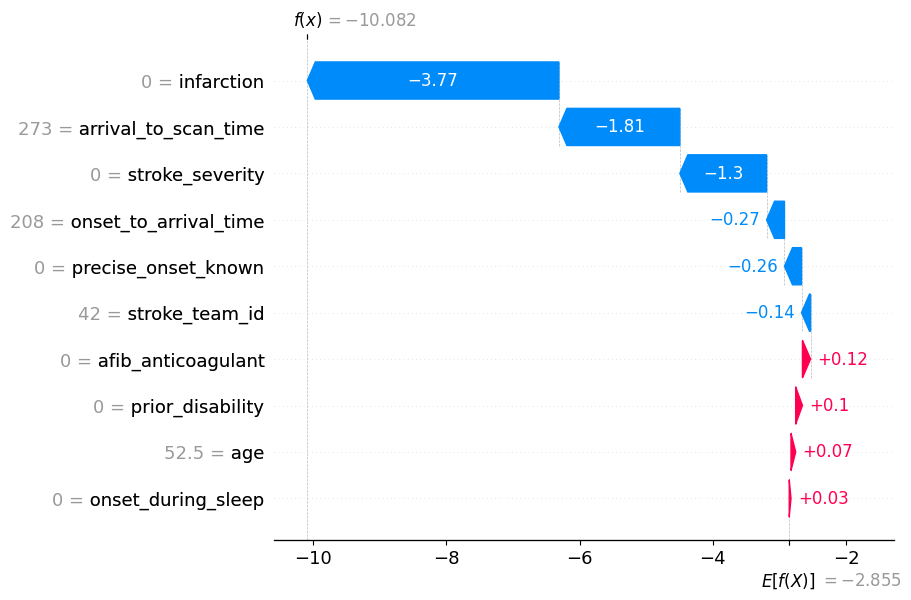

In [7]:
# For LightGBM, need to construct a new object for plotting waterfall
class Shap_array:
    def __init__(self, shap_values_extended, row, class_index):
        self.values = shap_values_extended[row][:, class_index].values
        self.base_values = shap_values_extended[row].base_values[class_index]
        self.data = shap_values_extended[row].data
        self.display_data = shap_values_extended.display_data
        self.feature_names = shap_values_extended.feature_names

row = 100
class_index = 1

shap.waterfall_plot(Shap_array(shap_values_extended, row, class_index))

## Beeswarm

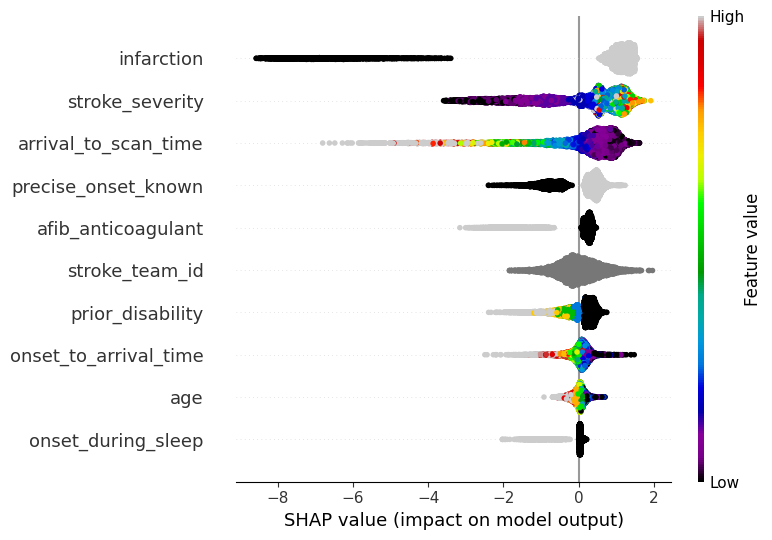

In [8]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values[1], 
                  features=X_test,
                  feature_names=features,
                  max_display=10,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)

filename = paths.output_folder + paths.notebook + paths.model_text + 'beeswarm.jpg'
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Get mean absolute SHAP values

In [9]:
mean_abs_shap = pd.Series(
    np.mean(np.abs(shap_values[1]), axis=0),
    index=features)
mean_abs_shap.sort_values(inplace=True, ascending=False)
mean_abs_shap.round(4)

infarction               1.9607
stroke_severity          1.0368
arrival_to_scan_time     0.9068
precise_onset_known      0.5643
afib_anticoagulant       0.4510
stroke_team_id           0.4007
prior_disability         0.3578
onset_to_arrival_time    0.2323
age                      0.1342
onset_during_sleep       0.1007
dtype: float64

## Get stroke team SHAP

In [10]:
# DataFrame of hopsital SHAP values for all patients
all_team_shap = pd.DataFrame()
all_team_shap['team_id'] = X_test['stroke_team_id']
all_team_shap['SHAP'] = hospital_shap_values = shap_values[1][:,4]

# Get summary for teams
team_shap = pd.DataFrame()
team_shap['SHAP_mean'] = all_team_shap.groupby('team_id').mean()
team_shap['SHAP_std'] = all_team_shap.groupby('team_id').std()

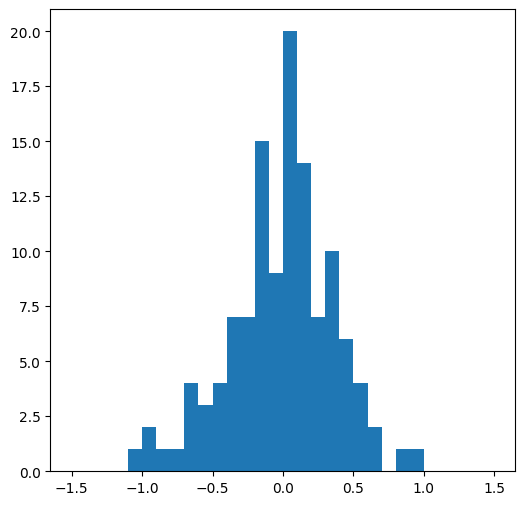

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(team_shap['SHAP_mean'], bins=np.arange(-1.5, 1.51, 0.1))

plt.show()

In [12]:
mean_shap = np.mean(team_shap['SHAP_mean'])
std_shap = np.std(team_shap['SHAP_mean'])
print(f'Mean hospital SHAP: {mean_shap:0.3f}')
print(f'Mean hospital SHAP STDdev: {std_shap:0.3f}')

Mean hospital SHAP: -0.008
Mean hospital SHAP STDdev: 0.369
